# Spatial Patterns of Gentrification Spurred by Airbnbs in London

## 1. Packages

**Fundamental Packages**

In [1]:
# Essentials
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os


# Clustering
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer

# Reproducibility
import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

# Standiser
mms  = MinMaxScaler(feature_range=(-1,1))
stds = StandardScaler()
rbs  = RobustScaler()
pts  = PowerTransformer()

**NLP-Specific Packages**

In [2]:
# These are specific to NLP
import nltk

from bs4 import BeautifulSoup

**Customised Functions**

In [3]:
## Caching function

import os
from requests import get
from urllib.parse import urlparse

# This is the cache function
def cache_data(src:str, dest:str) -> str:
    """Downloads and caches a remote file locally.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dest : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    # Check if dest+filename does *not* exist -- 
    # that would mean we have to download it!
    # os.path.getsize() gets the size of the file
    # if it doesn't exist, its size is less than 1
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 1:
        
        print(f"{dfn} not found, downloading!")

        # Convert the path back into a list (without)
        # the filename -- we need to check that directories
        # exist first.
        path = os.path.split(dest)
        
        # Create any missing directories in dest(ination) path
        # -- os.path.join is the reverse of split (as you saw above)
        # but it doesn't work with lists... so I had to google how
        # to use the 'splat' operator! os.makedirs creates missing
        # directories in a path automatically.
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        # Download and write the file
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print('Done downloading...')

    else:
        print(f"Found {dfn} locally!")

    return dfn

## 2. Read in Data

Inside Airbnb Data are used for the analysis. 2019 Airbnb listings are scraped on November 5th, 2019 and are hosted on [Kaggle](https://www.kaggle.com/datasets/labdmitriy/airbnb/), and 2023 listings scraped on the 6th of September 2023 can be found on [Inside Airbnb](http://insideairbnb.com/get-the-data/).

**Airbnb Data**

In [4]:
## 2019 Airbnb Raw Data
airbnb_raw_2019 = pd.read_csv('data/airbnb/2019_listings.csv', low_memory=False)
print(f"Data frame is {airbnb_raw_2019.shape[0]:,} x {airbnb_raw_2019.shape[1]}")

Data frame is 85,068 x 106


In [5]:
# 2023 Airbnb Raw Data
airbnb_raw_2023 = pd.read_csv('data/airbnb/2023_listings.csv.gz', compression='gzip', low_memory=False)
print(f"Data frame is {airbnb_raw_2023.shape[0]:,} x {airbnb_raw_2023.shape[1]}")

Data frame is 87,946 x 75


**Borough GIS Image**

In [6]:
# some shapefiles
spath = 'https://github.com/jreades/fsds/blob/master/data/src/' # source path
ddir  = os.path.join('data','geo') # destination directory
boros = gpd.read_file( cache_data(spath+'Boroughs.gpkg?raw=true', ddir) )

Found data/geo/Boroughs.gpkg locally!


In [7]:
# boros
boros.head(n=1)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,Kingston upon Thames,E09000021,"3,726.12",0.00,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


## 3. Preliminary Data Cleaning

Before selecting specific columns, we will clean the entire dataset.

In [8]:
# Here I am parameterising the data by defining the columns so I can work with them more easily. 

cols = ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 
        'host_since', 'host_location', 'host_about', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 
        'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'license', 'reviews_per_month', 'has_availability', 'calendar_last_scraped']

In [9]:
# columns that seem to have values that should be booleans are converted here 
# (i.e., those that have t/f as strings). It also makes the data more managable.
bcols = ['instant_bookable', 'host_has_profile_pic', 'host_identity_verified','host_is_superhost', 'has_availability']

In [10]:
# 2019 Raw Airbnb Data 
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw_2019[b] = airbnb_raw_2019[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


In [11]:
# 2023 Raw Airbnb Data 
for b in bcols:
    print(f"Converting {b}")
    airbnb_raw_2023[b] = airbnb_raw_2023[b].replace({'f':False, 't':True}).astype('bool')

Converting instant_bookable
Converting host_has_profile_pic
Converting host_identity_verified
Converting host_is_superhost
Converting has_availability


### Date

In [12]:
dates = ['last_scraped','host_since', 'calendar_last_scraped','first_review','last_review']

In [13]:
print("Converting 2019 Airbnb listings...\n")
for d in dates:
    print("Converted " + d)
    airbnb_raw_2019[d] = pd.to_datetime(airbnb_raw_2019[d], infer_datetime_format=True)

Converting 2019 Airbnb listings...

Converted last_scraped
Converted host_since
Converted calendar_last_scraped
Converted first_review
Converted last_review


In [14]:
print("Converting 2023 Airbnb listings...\n")
for d in dates:
    print("Converted " + d)
    airbnb_raw_2023[d] = pd.to_datetime(airbnb_raw_2023[d], infer_datetime_format=True)

Converting 2023 Airbnb listings...

Converted last_scraped
Converted host_since
Converted calendar_last_scraped
Converted first_review
Converted last_review


### Category

In [15]:
# converting to categories, here we are selecting the columns that use categorical data. 
# this allows for more nuanced use of data in later analysis.
cats = ['property_type','room_type', 'host_location', 'host_response_time', 'host_location', 'neighbourhood_cleansed']

In [16]:
print("Converting 2019 Airbnb listings...\n")
for c in cats:
    print(f"Converted {c}")
    airbnb_raw_2019[c] = airbnb_raw_2019[c].astype('category')

Converting 2019 Airbnb listings...

Converted property_type
Converted room_type
Converted host_location
Converted host_response_time
Converted host_location
Converted neighbourhood_cleansed


In [17]:
print("Converting 2023 Airbnb listings...\n")
for c in cats:
    print(f"Converted {c}")
    airbnb_raw_2023[c] = airbnb_raw_2023[c].astype('category')

Converting 2023 Airbnb listings...

Converted property_type
Converted room_type
Converted host_location
Converted host_response_time
Converted host_location
Converted neighbourhood_cleansed


### Price and String Values

In [18]:
#2019 Data

money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
print("Converting 2019 Airbnb listings...\n")
for m in money:
    print(f"Converted {m}")
    airbnb_raw_2019[m] = airbnb_raw_2019[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')

Converting 2019 Airbnb listings...

Converted price


In [19]:
# 2023 Data

money = ['price']

# part of the issue here was that you had to remove the commas as well 
# because it wouldn't convert to a float if you just removed the $
print("Converting 2023 Airbnb listings...\n")
for m in money:
    print(f"Converted {m}")
    airbnb_raw_2023[m] = airbnb_raw_2023[m].str.replace('$','', 
                                              regex=False).str.replace(',','', 
                                                                       regex=False).astype('float')

Converting 2023 Airbnb listings...

Converted price


### Converting other Values to Pandas Integers
This will make the data into integers so that it is more easily usable.

In [20]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']

print("Converting 2019 Airbnb listings...\n")
for i in ints:
    print(f"Converted {i}")
    try:
        airbnb_raw_2019[i] = airbnb_raw_2019[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converted to unsigned 16-bit integer!!!")
        airbnb_raw_2019[i] = airbnb_raw_2019[i].astype('float').astype(pd.UInt16Dtype())

Converting 2019 Airbnb listings...

Converted id
Converted host_id
Converted host_listings_count
  - !!!Converted to unsigned 16-bit integer!!!
Converted host_total_listings_count
  - !!!Converted to unsigned 16-bit integer!!!
Converted accommodates
Converted beds
  - !!!Converted to unsigned 16-bit integer!!!
Converted minimum_nights
Converted maximum_nights
Converted availability_365


In [21]:
ints  = ['id','host_id','host_listings_count','host_total_listings_count','accommodates',
         'beds','minimum_nights','maximum_nights','availability_365']
print("Converting 2023 Airbnb listings...\n")
for i in ints:
    print(f"Converted {i}")
    try:
        airbnb_raw_2023[i] = airbnb_raw_2023[i].astype('float').astype('int')
    except ValueError as e:
        print("  - !!!Converted to unsigned 16-bit integer!!!")
        airbnb_raw_2023[i] = airbnb_raw_2023[i].astype('float').astype(pd.UInt16Dtype())

Converting 2023 Airbnb listings...

Converted id
Converted host_id
Converted host_listings_count
  - !!!Converted to unsigned 16-bit integer!!!
Converted host_total_listings_count
  - !!!Converted to unsigned 16-bit integer!!!
Converted accommodates
Converted beds
  - !!!Converted to unsigned 16-bit integer!!!
Converted minimum_nights
Converted maximum_nights
Converted availability_365


### Create a new DataFrame

This dataframe will be used for analysis which contains columns that we need!

In [22]:
fcols = ['id', 'name', 'description', 'host_id', 'host_location',
       'host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'property_type', 'room_type', 'minimum_nights',
       'maximum_nights', 'neighbourhood_cleansed', 'price']

In [23]:
airbnb_2019 = airbnb_raw_2019[fcols]
print(f"Data frame is {airbnb_2019.shape[0]:,} x {airbnb_2019.shape[1]}")

Data frame is 85,068 x 15


In [24]:
airbnb_2023 = airbnb_raw_2023[fcols]
print(f"Data frame is {airbnb_2023.shape[0]:,} x {airbnb_2023.shape[1]}")

Data frame is 87,946 x 15


### Setting CRS and Spatial Subsetting

**CSV to Geometry**

In [25]:
# create a column of geometry
gdf_2019 = gpd.GeoDataFrame(airbnb_2019, geometry=gpd.points_from_xy(airbnb_2019.longitude, airbnb_2019.latitude))

In [26]:
# create a column of geometry
gdf_2023 = gpd.GeoDataFrame(airbnb_2023, geometry=gpd.points_from_xy(airbnb_2023.longitude, airbnb_2023.latitude))

In [27]:
# set aribnb 2019/2023 crs
gdf_2019.set_crs(epsg=4326, inplace=True)
gdf_2023.set_crs(epsg=4326, inplace=True)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,92644,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,498201,"London, United Kingdom",1,1,51.44,-0.19,Private room in rental unit,Private room,2,730,Wandsworth,42.00,POINT (-0.18739 51.44201)
1,93015,Rental unit in Hammersmith · ★4.82 · 2 bedroom...,Gorgeous 2 bed ground floor apartment with per...,499704,"London, United Kingdom",1,2,51.50,-0.22,Entire rental unit,Entire home/apt,5,240,Hammersmith and Fulham,175.00,POINT (-0.21707 51.49993)
2,13913,Rental unit in Islington · ★4.80 · 1 bedroom ·...,My bright double bedroom with a large window h...,54730,"London, United Kingdom",3,4,51.57,-0.11,Private room in rental unit,Private room,1,29,Islington,79.00,POINT (-0.11270 51.56861)
3,15400,Rental unit in London · ★4.80 · 1 bedroom · 1 ...,Lots of windows and light. St Luke's Gardens ...,60302,"Royal Borough of Kensington and Chelsea, Unite...",1,12,51.49,-0.17,Entire rental unit,Entire home/apt,7,30,Kensington and Chelsea,150.00,POINT (-0.16813 51.48780)
4,93734,Condo in London · ★4.62 · 1 bedroom · 1 bed · ...,<b>During your stay</b><br />I’m a professiona...,497514,"London, United Kingdom",1,1,51.48,0.01,Private room in condo,Private room,4,365,Greenwich,46.00,POINT (0.01442 51.47618)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,973781286754517248,Rental unit in Greater London · ★New · 1 bedro...,Enjoy a Experience unique look in the center o...,498408783,"London, United Kingdom",2,2,51.51,-0.14,Entire rental unit,Entire home/apt,2,1125,Westminster,275.00,POINT (-0.13598 51.51486)
87942,973801695874775296,Rental unit in Greater London · ★New · 1 bedro...,La Casita is a unique one bedroom flat in Sout...,36645347,"London, United Kingdom",1,1,51.46,-0.06,Entire rental unit,Entire home/apt,3,21,Southwark,145.00,POINT (-0.05546 51.45904)
87943,973811685656289792,Home in Greater London · ★New · 1 bedroom · 5 ...,NaN,340514057,NaN,1,1,51.41,-0.24,Private room in home,Private room,1,45,Merton,160.00,POINT (-0.23613 51.40610)
87944,973882998775927936,Home in Greater London · ★New · 5 bedrooms · 5...,<b>The space</b><br />Looking for a spacious h...,439074505,NaN,2538,5217,51.45,-0.44,Entire home,Entire home/apt,1,365,Hounslow,680.00,POINT (-0.44432 51.45100)


**Reprojecting CRS**

In [28]:
# reproject airbnb crs
gdf_2019 = gdf_2019.to_crs(epsg=27700)
gdf_2023 = gdf_2023.to_crs(epsg=27700)

In [29]:
gdf_2023.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,room_type,minimum_nights,maximum_nights,neighbourhood_cleansed,price,geometry
0,92644,Rental unit in Earlsfield · ★4.57 · 1 bedroom ...,<b>The space</b><br />Hi everyone! I have 2 ro...,498201,"London, United Kingdom",1,1,51.44,-0.19,Private room in rental unit,Private room,2,730,Wandsworth,42.00,POINT (526073.474 173004.387)


In [30]:
# rename a column
gdf_2019.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)
gdf_2023.rename(columns = {'neighbourhood_cleansed':'borough'}, inplace = True)

In [31]:
# merge airbnb and borough shapefile 
boro_listings_2019 = gpd.sjoin(gdf_2019, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = 'index_right') # gdf contains index assigned per borough

boro_listings_2023 = gpd.sjoin(gdf_2023, boros.drop(
                        columns=['HECTARES', 'NONLD_AREA', 'ONS_INNER']), predicate='within'
                         ).drop(columns = 'index_right')

## 4. Listings with Words Tied to Gentrification: Basic NLP
Here, we target descriptions using basic text mining analysis with the aim of discerning Airbnb listings that might be tied to gentrification. The main purpose of this section is to identify on a map where listings that buy into narratives surrounding gentrification are located. We select these terms based on a wide array of news articles and academics work that like these words to gentrification. From the fetishisation of 'culture' to the governement policies, language shapes concrete change. We found that listings using words like trendy, revitalise, popular, edgy, vibrant, and authentic followed distinct spatial patterns.

In working on NLP, we drop all the description rows that have null values because they serve as the basis for this type of analysis.

In [32]:
gdf1 = boro_listings_2019.dropna(subset=['description'])
print(f"Now gdf has {gdf1.shape[0]:,} rows and {gdf1.shape[1]:,} columns")

gdf2 = boro_listings_2023.dropna(subset=['description'])
print(f"Now gdf has {gdf2.shape[0]:,} rows and {gdf2.shape[1]:,} columns")

Now gdf has 82,673 rows and 18 columns
Now gdf has 86,677 rows and 18 columns


In [33]:
gdf1[~gdf1.description.isna()].description.sample(10, random_state=42)

18299    Newly renovated flat and located on a beautifu...
15624    An award winning, very comfortable flat in qui...
18280    Peace and quiet right in the heart of East Lon...
33925    A flat with 2 double beds only a few minutes w...
55527    The flat is located in a former church hall bu...
38738    Professionally managed one bedroom apartment i...
21567    This is a 3 bedroom appartament with no living...
84775    Spacious 4 double bedroom, 2 bathroom, 4 beds ...
10200    Three fully furnished spacious bedrooms (2 dou...
6644     Located in popular Fulham area, my home is com...
Name: description, dtype: object

In [34]:
gdf1.description.iloc[56440]
#While many of the above end in ..., the dots do not appear to be part of the actual description
#but rather a way of shortening it in python.

'Top floor flat share with great light throughout the day and surrounded by gardens. The bedroom includes a corner study with views to the garden. You will be sharing the flat with 2 lovely people. Access to the bathroom, kitchen and living room is shared. There is a piano and a 50" TV in the living room. Happy to send extra pictures upon request :) The area has some of the best transport links in London; underground to Oxford Street in 12 minutes, direct trains to Gatwick and Luton Airports. 5 minutes from the tube, overground and 3 minutes from Thameslink trains to Gatwick, Luton and Central London!'

In [35]:
#Remove html. This uses a lambda function to apply the HTML parser across all rows of the dataframes.
for col in gdf1.select_dtypes(include='object'):
    gdf1['description'] = gdf1['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    
for col in gdf2.select_dtypes(include='object'):
    gdf2['description'] = gdf2['description'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())    

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [36]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf1['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [37]:
#remove punctuation
pattern = re.compile(r'[,\.!\-><=\(\)\[\]\/&\'\"’;\+\–\—]+')
punkt   = []
for l in gdf2['description']:
    punkt.append(re.sub(pattern, ' ', l))

In [38]:
#Regex for words often associated with gentrification:
gent_2019 = gdf1[gdf1.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitali(?:se|ze)|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent_2019.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 10,486 records for airbnbs in areas that might be gentrifying


In [39]:
#Regex for words often associated with gentrification:
gent_2023 = gdf2[gdf2.description.str.contains(
    r'\b(?:trend(?:y|iness|ing)|revitali(?:ze|se)|popular(?:ity|ness)|edgy|vibrant|authentic(?:ity)|cultur(?:e|al|ed))\b', 
                                        regex=True, flags=re.IGNORECASE)].copy()
print(f"Found {gent_2023.shape[0]:,} records for airbnbs in areas that might be gentrifying")

Found 8,120 records for airbnbs in areas that might be gentrifying


Below, we use the customised package called `textual` written by [John Reades](https://github.com/jreades/fsds/tree/master/practicals). It serves more or less the same function as the above cleaning but in more depth. For example, it will go further to remove stopwords, words with accents, special characters, digits, as well as lemmatise the text. The preliminary cleaning above is important because it ended up catching more listings (about 100) than without the NLP.

In [40]:
%load_ext autoreload
%autoreload 2
from textual import *

[nltk_data] Error loading wordnet: <urlopen error [Errno 99] Cannot
[nltk_data]     assign requested address>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 99] Cannot assign requested address>


In [41]:
# I commented it cos it took a long time to run this code chunk
gent_2019['description_norm'] = gent_2019.description.apply(normalise_document, remove_digits=True)

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [42]:
# I commented it cos it took a long time to run this code chunk
gent_2023['description_norm'] = gent_2023.description.apply(normalise_document, remove_digits=True)

/opt/conda/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [43]:
print(boros.crs)
print(gent_2019.crs)
print(gent_2023.crs)

epsg:27700
epsg:27700
epsg:27700


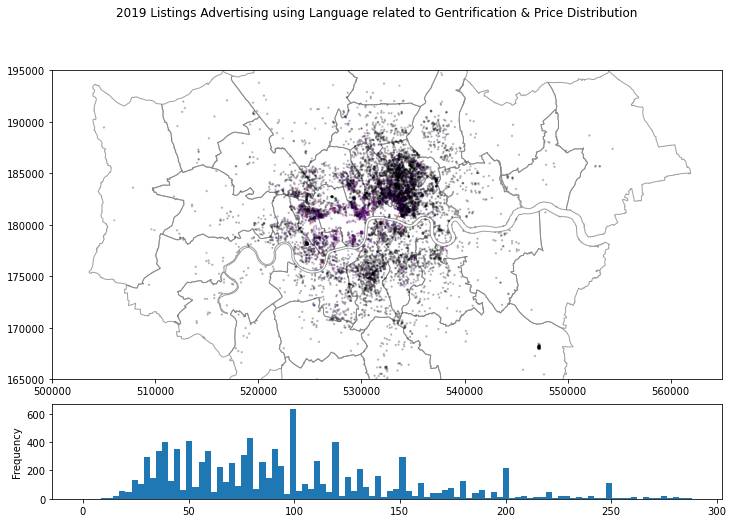

In [44]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent_2019.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent_2019[gent_2019.price<gent_2019.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("2019 Listings Advertising using Language related to Gentrification & Price Distribution")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

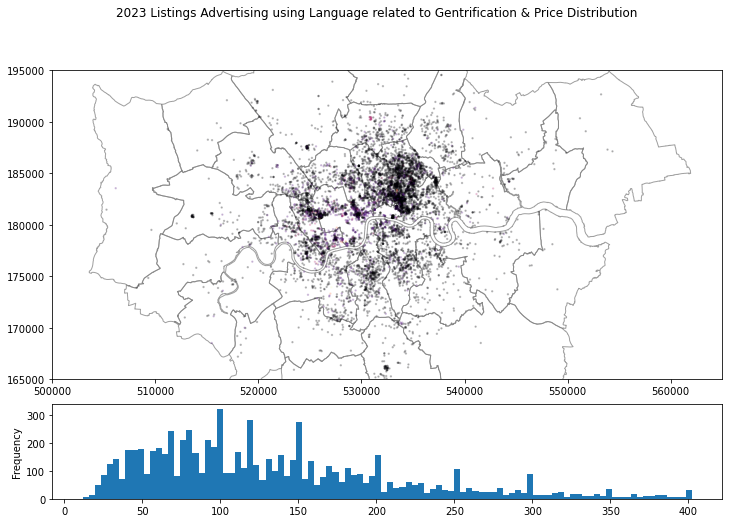

In [45]:
f,ax = plt.subplots(1,1,figsize=(12,8))

# The second one is on column2, spread on 3 columns
ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
boros.plot(edgecolor='grey', facecolor='none', linewidth=1, alpha=0.75, ax=ax1)
gent_2023.plot(markersize=2, column='price', cmap='magma', alpha=0.2, scheme='Fisher_Jenks_Sampled', ax=ax1)

ax1.set_xlim([500000, 565000])
ax1.set_ylim([165000, 195000]);

# The last one is spread on 1 column only, on the 4th column of the second line.
ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
gent_2023[gent_2023.price<gent_2023.price.quantile(0.95)].price.plot.hist(bins=100, ax=ax2)
#ax2.set_ylim([0,10000])

plt.suptitle("2023 Listings Advertising using Language related to Gentrification & Price Distribution")
# plt.savefig("Affordable_Listings.png", dpi=150)
plt.show()

## 5. Data Cleaning

In this part, we will only keep a few columns for analysis.

**First**, we will count the Airbnb listings based on room types. The number of listings per borough will be standardised which would allow us for a comparison. Afterwards, PCA will be conducted to reduce the dimension of our room types.

**Second**, mean/median price of Airbnb listings will be calculated which will be standardised as well

Once these procedures are completed, we will go on with spatial autocorrelation analysis.

### 5.1. PCA

In [46]:
# Merge gentrified 2019 airbnb data with London borough shapefile 
gent19 = pd.merge(gent_2019, boros, how = 'left', on = 'NAME')

In [47]:
# Merge gentrified 2023 airbnb data with London borough shapefile 
gent23 = pd.merge(gent_2023, boros, how = 'left', on = 'NAME')

In [48]:
gent23.head(n=1)

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,...,price,geometry_x,NAME,GSS_CODE_x,description_norm,GSS_CODE_y,HECTARES,NONLD_AREA,ONS_INNER,geometry_y
0,374594,Rental unit in London · ★4.60 · 2 bedrooms · 3...,"Beautiful 2 bedroom flat in Tooting Broadway, ...",1749231,"London, United Kingdom",1,2,51.42,-0.16,Entire rental unit,...,80.00,POINT (527771.691 170753.364),Wandsworth,E09000032,beautiful bedroom flat toot broadway perfect b...,E09000032,"3,522.02",95.60,T,"MULTIPOLYGON (((523489.600 176224.800, 523500...."


In [49]:
# drop repeated column
gent19.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)
gent23.drop(columns = ['NAME', 'GSS_CODE_x'], inplace =True)

In [50]:
gent19.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)
gent23.rename(columns = {'GSS_CODE_y': 'GSS_CODE'}, inplace = True)

In [51]:
# Check room types of 2019 airbnb listings

pivot19 = gent19.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])


# Check room types of 2023 airbnb listings
pivot23 = gent23.groupby(['GSS_CODE','room_type']
    
    # listing_url is an unique identifier and 
    # that is why we count number of rooms based on it
        ).host_id.agg(Count='count').reset_index().pivot(
    index='GSS_CODE', columns=['room_type'], values=['Count'])

In [52]:
# Have a look at the counts of each room type
# Hackney has the highest number of airbnb listings related to gentrification
pivot19

Count                                    
room_type Entire home/apt Hotel room Private room Shared room
GSS_CODE                                                     
E09000001              32          8            5           0
E09000002               5          3           12           0
E09000003              31          1           26           0
E09000004               1          0            1           0
E09000005             146          1           91           2
E09000006              19         36           19           0
E09000007             524          8          192           5
E09000008              33          0           36           0
E09000009              36          1           39           0
E09000010              11          0            5           2
E09000011              36          0           35           0
E09000012            1132          3          757           5
E09000013             285          5           87           0
E09000014             131          0          117           2
E09000015               7          0           11           0
E09000016               1          0            6           0
E09000017               3          0            2           0
E09000018              24          0           19           0
E09000019             678         13          250           5
E09000020             463         17           78           0
E09000021               7          0            6           0
E09000022             448          1          340           7
E09000023             108          0           97           5
E09000024              31          0           16           1
E09000025              48          1           47           0
E09000026               5          0            6           0
E09000027              19          0           13           0
E09000028             483          4          285           0
E09000029               2          0            2           0
E09000030             882         25          618           4
E09000031             102          0           83           1
E09000032             218          2          126           1
E09000033             777         20          141           1

In [53]:
# We can check that Entire home/apt and Private room
# are predominant
print(pivot19.sum())
print(pivot23.sum())

       room_type      
Count  Entire home/apt    6728
       Hotel room          149
       Private room       3568
       Shared room          41
dtype: int64
       room_type      
Count  Entire home/apt    5964
       Hotel room           11
       Private room       2127
       Shared room          18
dtype: int64


In [54]:
# drop insignificant room_type

pivot19.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot19.drop(columns = ['Hotel room', 'Shared room'], inplace = True)


pivot23.columns = ['Entire home/apt','Hotel room','Private room','Shared room']
pivot23.drop(columns = ['Hotel room', 'Shared room'], inplace = True)

In our original notebook, we rescaled the counts of room types using power transformation. Then, we applied PCA to reduce dimensionality. After PCA, we again rescaled the PCA data using minmaxscaler. PCA data is already standardised so I am not sure if we need to rescale the data as what we want to do is to extract the first PCA component out of PCA data. 


So, here is what I did. First, I rescaled the counts of room types using minmaxscaler. Then, I applied PCA to reduce dimensions of our original data and I extracted the first PCA component.

Could you please tell me your rationale behind this?:)

P.S. I commented out our original code chunks.

In [55]:
pivot23.head()

,Entire home/apt,Private room
GSS_CODE,,
E09000001,100,4
E09000002,10,14
E09000003,72,21
E09000004,4,3
E09000005,143,72


In [56]:
# # Original Code Chunk!!

# pivot_norm19 = pd.DataFrame(index=pivot19.index)
# for c in pivot19.columns.to_list():
#     # Power Transform
#     # count to normalised values
#     pivot_norm19[c] = pts.fit_transform(pivot19[c].to_numpy().reshape(-1,1))

# pivot_norm23 = pd.DataFrame(index=pivot23.index)
# for c in pivot23.columns.to_list():
#     # Power Transform
#     # count to normalised values
#     pivot_norm23[c] = pts.fit_transform(pivot23[c].to_numpy().reshape(-1,1)) 

In [57]:
# We only have two columns in our pivot_norm
# And 94.9% of these can be explained by pca component 1 in 2019 airbnb listings
# And 94.6% of these can be explained by pca component 1 in 2023 airbnb listings
# pcomp = PCA(n_components= 2, random_state=42)
# rd19    = pcomp.fit_transform(pivot_norm19)
# print(f"The explained variance of each component of 2019 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
# explained_variance = pcomp.explained_variance_ratio_


# rd23    = pcomp.fit_transform(pivot_norm23)
# print(f"The explained variance of each component of 2023 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
# explained_variance = pcomp.explained_variance_ratio_

In [58]:
# # we are only choosing to include the first component

# airbnb_pca19 = pd.DataFrame(
#     # rescaling data with minmax scaler
#     # as we are interested in the first PCA component,
#     # we specify it with rd[:,0]
#     # reshape(-1, 1) is used to convert the 1D array into a 2D array-like structure with a single column. 
#     # reshape(1, -1) reshapes the result into a 2D array-like structure with one row and 
#     # as many columns as needed to preserve the original data. 
#                 {'2019_Airbnb Component 1': mms.fit_transform(rd19[:,0].reshape(-1,1)).reshape(1,-1)[0]},
#                 index=pivot19.index)

# airbnb_pca23 = pd.DataFrame(
#     # rescaling data with minmax scaler
#     # as we are interested in the first PCA component,
#     # we specify it with rd[:,0]
#                 {'2023_Airbnb Component 1': mms.fit_transform(rd23[:,0].reshape(-1,1)).reshape(1,-1)[0]},
#                 index=pivot23.index)

# # In case, you want to keep two cols
# #airbnb_pca = pd.DataFrame(
#     # rescaling data with minmax scaler
#  #               {'2019_Airbnb Component 1': mms.fit_transform(rd[:,0].reshape(-1,1)).reshape(1,-1)[0], 
#   #              '2019_Airbnb Component 2': mms.fit_transform(rd[:,1].reshape(-1,1)).reshape(1,-1)[0]},
#    #             index=pivot.index)

# airbnb_pca23.head()

In [59]:
# NEW CODE CHUNK!!
# rescale count of listings using minmaxscaler

pivot_norm19 = pd.DataFrame(index=pivot19.index)
for c in pivot19.columns.to_list():
    # Minmaxscaler
    # count to normalised values
    # the original column is 1D array.
    # reshape(-1,1) converts this 1D array into a 2D array 
    # where the number of rows is determined by the data's length
    # -1 tells NumPy to calculate the number of rows based on the length of the original 1D array
    # reshape(-1,1) ensures that the data has the correct shape (2D) 
    # that the MinMaxScaler expects for transformation.
    pivot_norm19[c] = mms.fit_transform(pivot19[c].to_numpy().reshape(-1,1))

pivot_norm23 = pd.DataFrame(index=pivot23.index)
for c in pivot23.columns.to_list():
    # Power Transform
    # count to normalised values
    pivot_norm23[c] = mms.fit_transform(pivot23[c].to_numpy().reshape(-1,1))    
    

In [60]:
# We only have two columns in our pivot_norm
# And 94.9% of these can be explained by pca component 1 in 2019 airbnb listings
# And 94.6% of these can be explained by pca component 1 in 2023 airbnb listings
pcomp = PCA(n_components= 2, random_state=42)
rd19    = pcomp.fit_transform(pivot_norm19)
print(f"The explained variance of each component of 2019 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_


rd23    = pcomp.fit_transform(pivot_norm23)
print(f"The explained variance of each component of 2023 listings is: {', '.join([f'{x*100:.2f}%' for x in pcomp.explained_variance_ratio_])}")
explained_variance = pcomp.explained_variance_ratio_


The explained variance of each component of 2019 listings is: 94.90%, 5.10%
The explained variance of each component of 2023 listings is: 94.65%, 5.35%


PCA results indicate that the first PCA component explains about 95% of total variance. Thus, it seems reasonable to only keep the first component. 

In [61]:
# keep only first PCA component
airbnb_pca19 = pd.DataFrame(
    {'2019_Airbnb Component 1': rd19[:,0]}, index = pivot19.index)

airbnb_pca23 = pd.DataFrame(
    {'2023_Airbnb Component 1': rd23[:,0]}, index = pivot23.index)

airbnb_pca23.head()

,2023_Airbnb Component 1
GSS_CODE,
E09000001,-0.30
E09000002,-0.40
E09000003,-0.29
E09000004,-0.44
E09000005,-0.03


In [62]:
# Add the airbnb_pca to the original gent19 and gent22 file

# merge the data based on GSS_CODE
ldn_gss_idx19 = gent19.set_index('GSS_CODE')
ldn_gss_idx23 = gent23.set_index('GSS_CODE')
rs19 = pd.merge(ldn_gss_idx19, airbnb_pca19, left_index=True, right_index = True)
rs23 = pd.merge(ldn_gss_idx23, airbnb_pca23, left_index=True, right_index = True)

print(len(rs19))
print(len(rs23))

10486
8120


In [63]:
rs19.head()

,id,name,description,host_id,host_location,host_listings_count,host_total_listings_count,latitude,longitude,property_type,...,maximum_nights,borough,price,geometry_x,description_norm,HECTARES,NONLD_AREA,ONS_INNER,geometry_y,2019_Airbnb Component 1
GSS_CODE,,,,,,,,,,,,,,,,,,,,,
E09000001,482178,Great St Paul's and City location,This listing is our own home and not a managed...,2176101,"London, England, United Kingdom",2,2,51.52,-0.09,Apartment,...,14,City of London,140.00,POINT (532283.423 181370.784),listing home manage property fantastic locatio...,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.41
E09000001,847464,"Luxury flat,Zone1,2bed/2bath/Lounge",PLEASE KINDLY ASK FOR AVAILABILITY BEFORE BOOK...,1517803,"London, United Kingdom",25,25,51.51,-0.08,Apartment,...,300,City of London,220.00,POINT (533220.531 180927.892),please kindly ask availability book please get...,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.41
E09000001,7754615,"Modern, zone 1, Central London",Beautiful refurbished central London apartment...,37213616,London,1,1,51.52,-0.11,Apartment,...,1125,City of London,99.00,POINT (531044.008 181536.743),beautiful refurbish central london apartment l...,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.41
E09000001,16276053,Spacious Double Room in Zone 1 near Shoreditch,This huge double-room with king size bed will ...,734407,"London, United Kingdom",1,1,51.52,-0.08,Apartment,...,20,City of London,35.00,POINT (533513.129 181525.353),huge double room king size bed comfortably fit...,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.41
E09000001,16717265,"St Paul's Cathedral. Spacious studio, entire f...",Studio flat in the heart of London. This is a...,110789326,"London, England, United Kingdom",2,2,51.52,-0.10,Apartment,...,21,City of London,126.00,POINT (531938.056 181730.135),studio flat heart london entire place share sp...,314.94,24.55,T,"MULTIPOLYGON (((531145.100 180782.100, 531143....",-0.41


### 5.2. Median/Mean

In [64]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent19 = rs19.reset_index().loc[:, ['GSS_CODE', '2019_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1_19 = rs19.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent19['2019_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1_19.values.reshape(-1,1))), index=s1_19.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2_19 = rs19.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent19['2019_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2_19.values.reshape(-1,1))), index=s2_19.index)

new_gent19.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent19= new_gent19[['2019_Airbnb Component 1', '2019_median_price',
                   '2019_mean_price', 'geometry']]

new_gent19.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2019_Airbnb Component 1,2019_median_price,2019_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.41,1.00,1.00,POINT (532283.423 181370.784)


In [65]:
# Create a new dataframe that contains
# GSS_CODE, PCA component1, geometry of each listing
new_gent23 = rs23.reset_index().loc[:, ['GSS_CODE', '2023_Airbnb Component 1', 'geometry_x']].copy().set_index('GSS_CODE')


# Append median price from cleaned listings grouped by GSS_CODE
s1_23 = rs23.groupby(by='GSS_CODE').price.agg('median')
# rescale median price by using minmaxscaler
new_gent23['2023_median_price'] = pd.Series(np.squeeze(mms.fit_transform(s1_23.values.reshape(-1,1))), index=s1_23.index)

# Append mean price from cleaned listings grouped by GSS_CODE
s2_23 = rs23.groupby(by='GSS_CODE').price.agg('mean')
# rescale mean price by using minmaxscaler
new_gent23['2023_mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2_23.values.reshape(-1,1))), index=s2_23.index)

new_gent23.rename(columns = {'geometry_x': 'geometry'}, inplace = True)
new_gent23= new_gent23[['2023_Airbnb Component 1', '2023_median_price',
                   '2023_mean_price', 'geometry']]

new_gent23.head(n=1)
# cldf is a merged numeric data of census tract and airbnb data
#s2 = cleaned.groupby(by='MSOA11CD').price.agg('mean')
#cldf['mean_price'] = pd.Series(np.squeeze(mms.fit_transform(s2.values.reshape(-1,1))), index=s2.index)

#cldf.drop(columns=['Subregion','Borough'], inplace=True)

#cldf.head()

,2023_Airbnb Component 1,2023_median_price,2023_mean_price,geometry
GSS_CODE,,,,
E09000001,-0.30,0.35,0.30,POINT (531181.088 181363.349)


# 6. Spatial Autocorrelation

This part will delve into whether there are any spatial trends persisting in London's Airbnbs. Identifying these patterns will allow us to understand which areas are most likely being gentrified.

In [66]:
# Visuals
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from pysal.viz import mapclassify

# Analysis
import pysal as ps
import esda
from pysal.lib import weights
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
from esda.moran import Moran_Local
from giddy.directional import Rose
from pysal.lib import weights
import libpysal
import splot
from splot.giddy import dynamic_lisa_composite

In [67]:
# Fonts to use in the mapping
tfont = {'fontname':'Liberation Sans Narrow', 'weight':'bold'}
bfont = {'fontname':'Liberation Sans Narrow', 'weight':'normal', 'horizontalalignment':'left'}
afont = {'fontname':'Liberation Sans Narrow', 'weight':'light'}

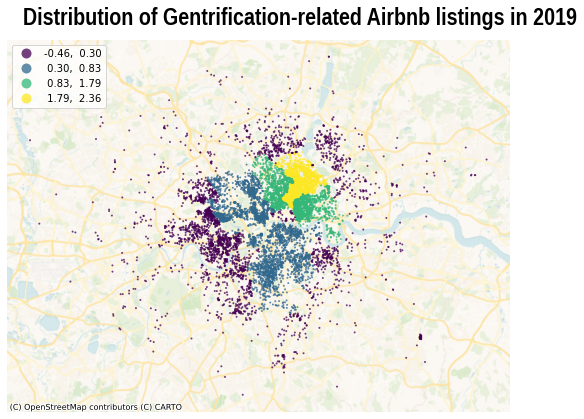

In [68]:
# Gentrification 2019 plotting
# Set up figure and a single axis
import contextily 

f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent19.plot(
    column="2019_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
    markersize = 4
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent19.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
f.subplots_adjust(top=1.6) # adjust the distance between the maps and the title
f.suptitle("Distribution of Gentrification-related Airbnb listings in 2019", x=0.15,y=1.2, ha='left', size=24, **tfont)
# Remove axes
ax.set_axis_off();

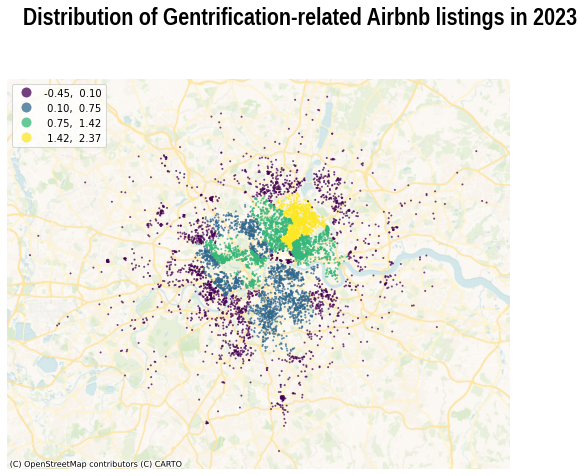

In [70]:
# Gentrification 2022 plotting
# Set up figure and a single axis
import contextily 


f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
new_gent23.plot(
    column="2023_Airbnb Component 1",
    cmap="viridis",
    scheme="quantiles",
    k=4,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
    markersize = 4
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=new_gent23.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
f.subplots_adjust(top=1.45) # adjust the distance between the maps and the title
f.suptitle("Distribution of Gentrification-related Airbnb listings in 2023", x=0.15,y=1.2, ha='left', size=24, **tfont)
# Remove axes
ax.set_axis_off();